epoch: 0, acc: 0.360, loss: 1.099
epoch: 100, acc: 0.420, loss: 1.077
epoch: 200, acc: 0.403, loss: 1.073
epoch: 300, acc: 0.413, loss: 1.053
epoch: 400, acc: 0.527, loss: 0.993
epoch: 500, acc: 0.600, loss: 0.899
epoch: 600, acc: 0.450, loss: 0.975
epoch: 700, acc: 0.650, loss: 0.832
epoch: 800, acc: 0.547, loss: 0.867
epoch: 900, acc: 0.547, loss: 0.872
epoch: 1000, acc: 0.627, loss: 0.798
epoch: 1100, acc: 0.710, loss: 0.681
epoch: 1200, acc: 0.747, loss: 0.600
epoch: 1300, acc: 0.770, loss: 0.523
epoch: 1400, acc: 0.717, loss: 0.544
epoch: 1500, acc: 0.737, loss: 0.515
epoch: 1600, acc: 0.837, loss: 0.402
epoch: 1700, acc: 0.847, loss: 0.387
epoch: 1800, acc: 0.880, loss: 0.337
epoch: 1900, acc: 0.840, loss: 0.368
epoch: 2000, acc: 0.887, loss: 0.298
epoch: 2100, acc: 0.840, loss: 0.345
epoch: 2200, acc: 0.860, loss: 0.338
epoch: 2300, acc: 0.910, loss: 0.244
epoch: 2400, acc: 0.883, loss: 0.265
epoch: 2500, acc: 0.900, loss: 0.241
epoch: 2600, acc: 0.820, loss: 0.398
epoch: 2700, 

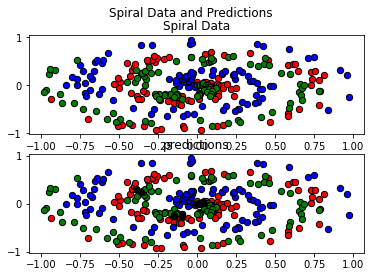

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import nnfs

from nnfs.datasets import vertical_data, spiral_data
nnfs.init()

# Dense layer
class Layer_Dense:
    # Layer initialization
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases
        # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)


class Activation_ReLU:
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):

        # Since we need to modify the original variable,
        # let's make a copy of the values first
        self.dinputs = dvalues.copy()
        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

class Activation_Softmax:
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)
        self.output = probabilities
    # Backward pass
    def backward(self, dvalues):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)
        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output and
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix,single_dvalues)
            
class Activation_Softmax_Loss_CategoricalCrossentropy():
    # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()
    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)
    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples
        
class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss
    
class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        # probabilities for target values - only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        # mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods
    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])
        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples

class Optimizer_SGD:
    def __init__(self, learning_rate=1.0, decay=0.0, momentum=0.0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
    def update_params(self, layer):
        if self.momentum:
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates
            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases
        layer.weights += weight_updates
        layer.biases += bias_updates
    def post_update_params(self):
        self.iterations += 1
        
# Create dataset
X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)
# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()
# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
# Create optimizer
optimizer = Optimizer_SGD(learning_rate=0.3, decay=1e-3, momentum=0.9)
# Train in loop
for epoch in range(10001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)
    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)
    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)
    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}')
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    # Update weights and biases
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    if epoch == 10000:
        print("Final accuracy: ", accuracy)
        fig, (ax1,ax2) = plt.subplots(2)
        x1 = X[y == 0]
        x2 = X[y == 1]
        x3 = X[y == 2]

        ax1.scatter(x1[:, 0], x1[:, 1], c='red', s=40, edgecolor='k')
        ax1.scatter(x2[:, 0], x2[:, 1], c='blue', s=40, edgecolor='k')
        ax1.scatter(x3[:, 0], x3[:, 1], c='green', s=40, edgecolor='k')
        # plt.scatter(X[:, 0], X[:, 1])
        ax1.set_title("Spiral Data")
        x1 = X[predictions == 0]
        x2 = X[predictions == 1]
        x3 = X[predictions == 2]
        x4 = X[predictions != y]
        ax2.scatter(x1[:, 0], x1[:, 1], c='red', s=40, edgecolor='k')
        ax2.scatter(x2[:, 0], x2[:, 1], c='blue', s=40, edgecolor='k')
        ax2.scatter(x3[:, 0], x3[:, 1], c='green', s=40, edgecolor='k')
        ax2.scatter(x4[:, 0], x4[:, 1], c='black', s=40, edgecolor='k')
        ax2.set_title("predictions")
        fig.suptitle("Spiral Data and Predictions")
        # fig.show()
        plt.show()